<a href="https://colab.research.google.com/github/Cralsic123/Model-selection-for-abalone-ring/blob/main/VT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer,r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, cross_val_predict
from xgboost import XGBRegressor, cv
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from scipy.stats import norm, skew
import optuna
from sklearn.ensemble import VotingRegressor

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c playground-series-s4e4

 83% 2.00M/2.41M [00:01<00:00, 2.11MB/s]
100% 2.41M/2.41M [00:01<00:00, 2.15MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('/content/playground-series-s4e4.zip', 'r') as zip_ref:
    zip_ref.extractall('./')



In [7]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

This time im gonna use the actual abalone dataset


In [8]:
train_org = pd.read_csv('/content/abalone.csv')

In [9]:
train_org.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [10]:
train_org = train_org.rename(columns={'Shucked weight': 'Whole weight.1',
                                      'Viscera weight': 'Whole weight.2'})

In [11]:
train = pd.concat([train, train_org]).drop(['id'], axis=1).drop_duplicates()
test = test.drop(['id'], axis=1)

In [12]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


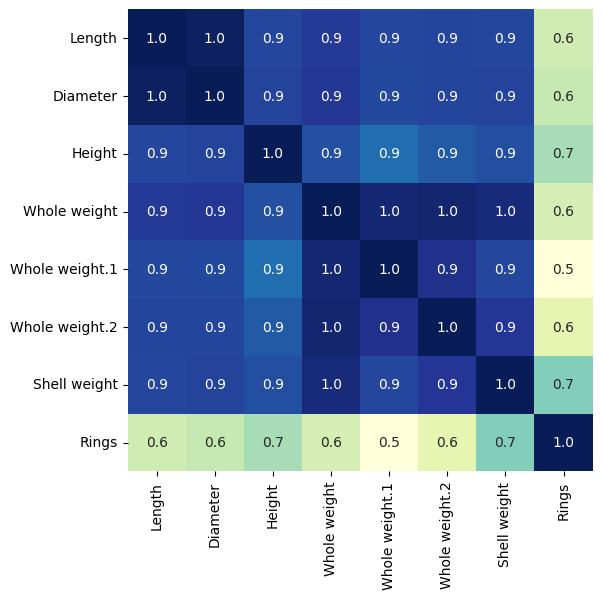

In [13]:
f, ax = plt.subplots(figsize=(6, 6))
corr = train.select_dtypes(exclude='object').corr(method='pearson')
sns.heatmap(corr, ax=ax, fmt = '0.1f', cmap = 'YlGnBu', annot=True, cbar=False)
plt.show()

In [14]:
train_raw = train.drop(['Sex'], axis=1)
num_features = train.select_dtypes(exclude=['object', 'int64']).columns.tolist()
train[num_features] = np.log1p(train[num_features])
train.Rings = np.log1p(train.Rings)
test[num_features] = np.log1p(test[num_features])

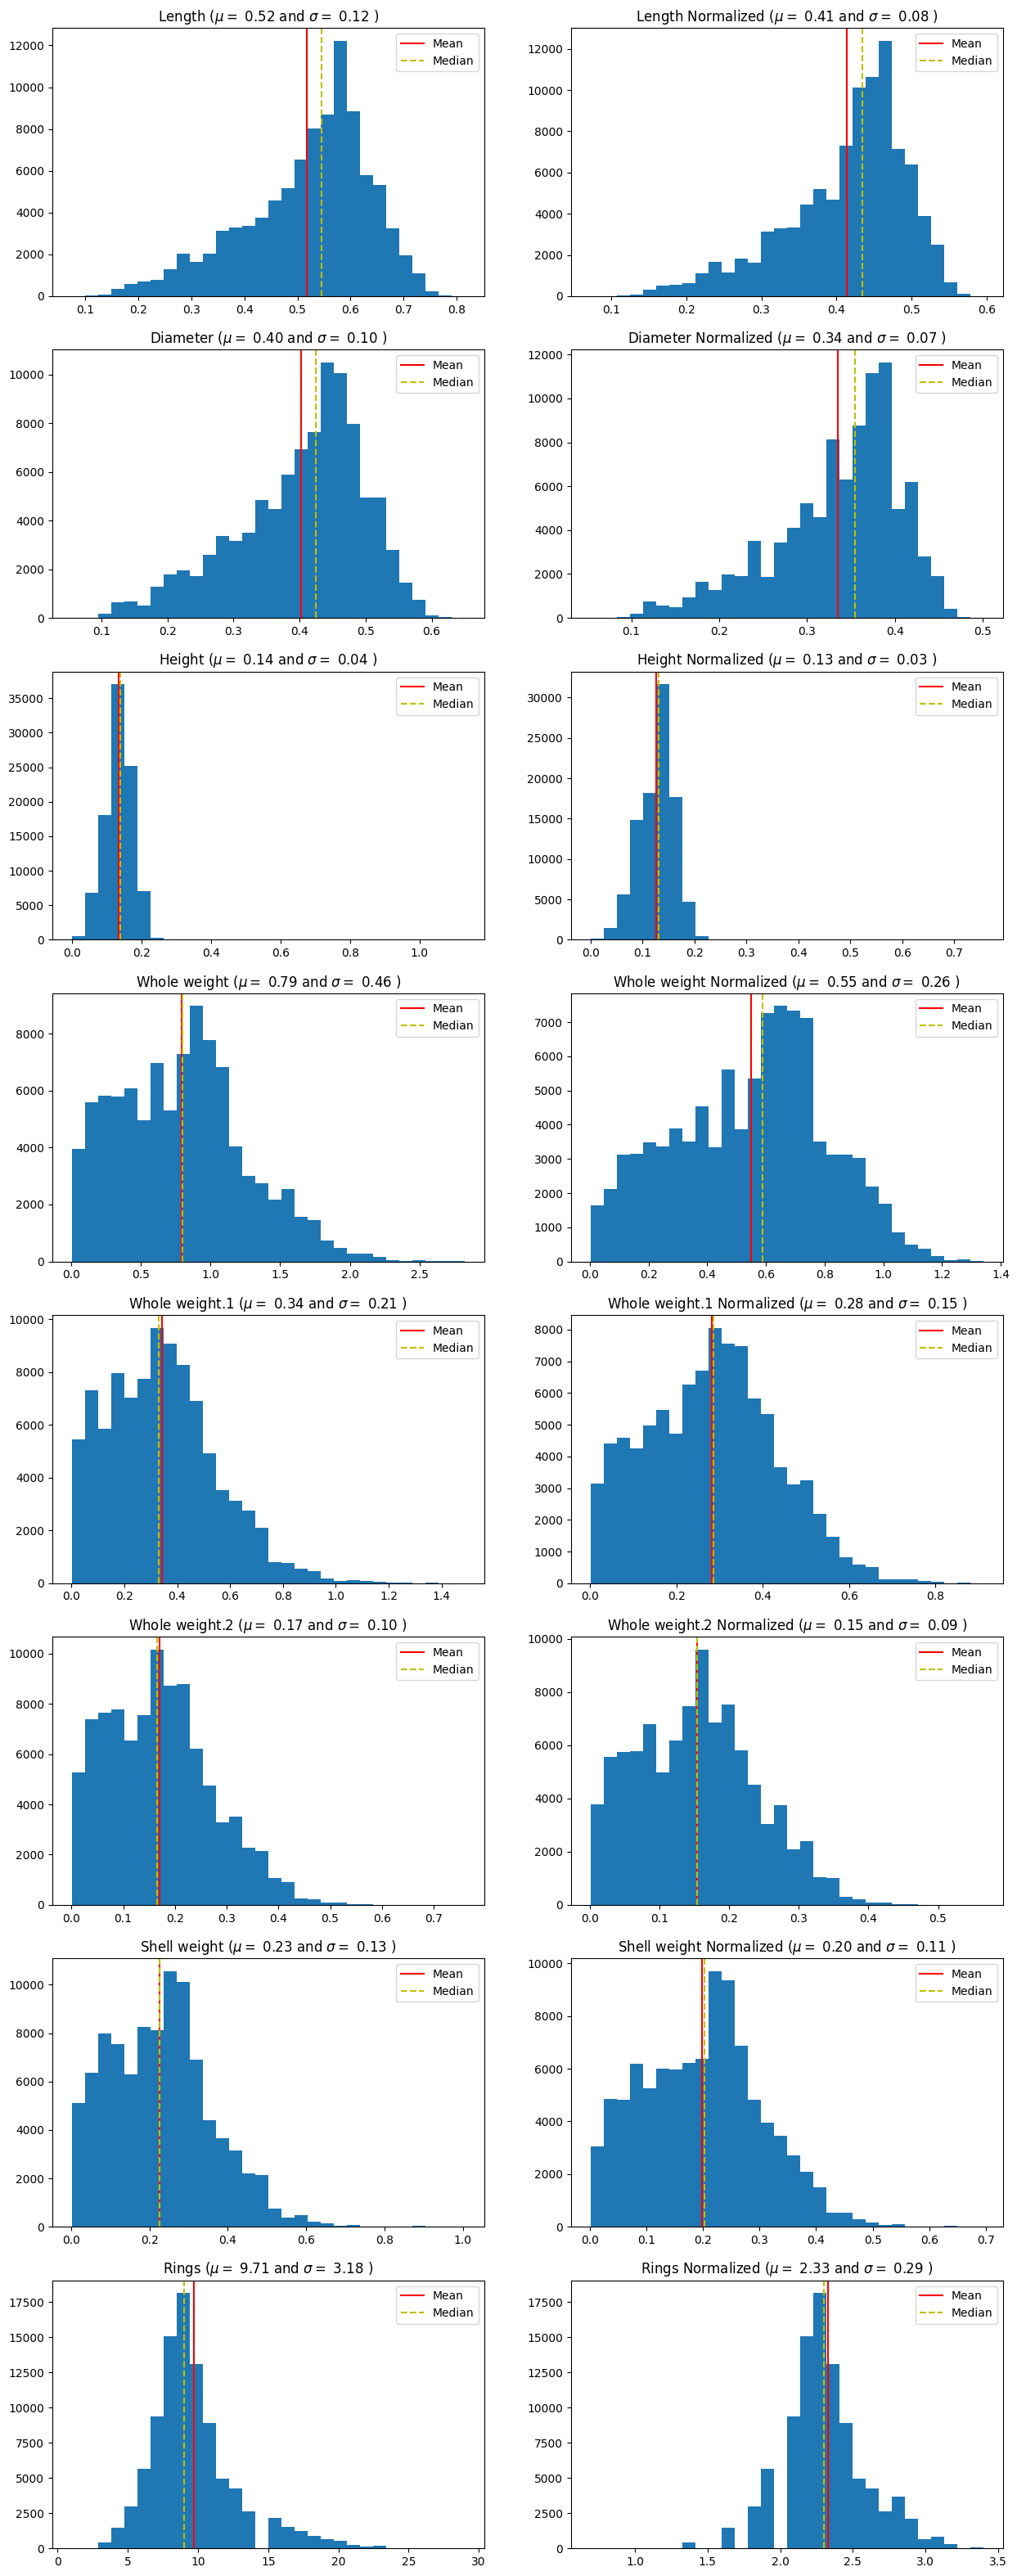

In [15]:
num_features = num_features + ['Rings']
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 40))

for (ax_r, ax_n), col in zip(axes, num_features):

    ax_r.set_title(f'{col} ($\mu=$ {train_raw[col].mean():.2f} and $\sigma=$ {train_raw[col].std():.2f} )')
    ax_r.hist(train_raw[col], bins=30)
    ax_r.axvline(train_raw[col].mean(), color='r', label='Mean')
    ax_r.axvline(train_raw[col].median(), color='y', linestyle='--', label='Median')
    ax_r.legend()

    ax_n.set_title(f'{col} Normalized ($\mu=$ {train[col].mean():.2f} and $\sigma=$ {train[col].std():.2f} )')
    ax_n.hist(train[col], bins=30)
    ax_n.axvline(train[col].mean(), color='r', label='Mean')
    ax_n.axvline(train[col].median(), color='y', linestyle='--', label='Median')
    ax_n.legend()

In [16]:
X = train.drop('Rings', axis=1)
y = train.Rings

In [17]:
cat_features = X.select_dtypes('object').columns.to_list()

X[cat_features] = X[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

In [18]:
xgb_params = {'booster': 'gbtree',
            'max_depth': 6,
            'n_estimators': 2000,
            'learning_rate': 0.017766114783902776,
            'min_child_weight': 17,
            'subsample': 0.787554747836242,
            'reg_alpha': 0.2737804193981823,
            'reg_lambda': 0.6546104880411592,
            'colsample_bytree': 0.7021619253205709,
            'random_state': 42,
            'objective': 'reg:squarederror',
            'n_jobs': -1,
            'enable_categorical': True,
            'tree_method':"hist"}

lgb_params = {'objective': 'regression_l2',
              'metric': 'rmse',
              'max_depth': 6,
              'num_leaves': 453,
              'min_child_samples': 28,
              'learning_rate': 0.045325661331864754,
              'min_child_weight': 16,
              'colsample_bytree': 0.49208196024189055,
              'reg_alpha': 0.48822484657746973,
              'reg_lambda': 0.8129601022847696,
              'random_state': 42,
              'n_estimators': 2000,
              'boosting_type': 'gbdt',
              'verbosity': -1}

cat_params = {'depth': 15,
             'max_bin': 464,
             'logging_level': 'Silent',
             'random_state': 42,
             'min_data_in_leaf': 78,
             'loss_function': 'RMSE',
             'grow_policy': 'Lossguide',
             'bootstrap_type': 'Bernoulli',
             'subsample': 0.84,
             'l2_leaf_reg': 8.37,
             'random_strength': 3.3,
             'learning_rate': 0.1,
             'n_estimators': 2000,
             'cat_features': cat_features}

In [19]:
estimators = [
    ('XGB', XGBRegressor(**xgb_params)),
    ('LGBM', LGBMRegressor(**lgb_params)),
    ('CAT', CatBoostRegressor(**cat_params))
]

In [20]:
folds = KFold(n_splits=10, shuffle=True, random_state=42)
scores = []
y_pred_test = []

voting_model = VotingRegressor(estimators=estimators, verbose=False)

for n_fold, (train_index, valid_index) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[valid_index], y.iloc[valid_index]

    voting_model.fit(X_train, y_train,)
    y_pred = voting_model.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(score)
    y_pred_test.append(voting_model.predict(test))
    print(f"FOLD {n_fold} RMSE: {score}")
print(f"Mean RMSE: {np.mean(scores)}")

FOLD 0 RMSE: 0.14720744831118943
FOLD 1 RMSE: 0.14948040298059068
FOLD 2 RMSE: 0.14547507093165365
FOLD 3 RMSE: 0.15212687617446335
FOLD 4 RMSE: 0.15065891519854757
FOLD 5 RMSE: 0.14493687274865874
FOLD 6 RMSE: 0.15025541117792876
FOLD 7 RMSE: 0.14777221817011424
FOLD 8 RMSE: 0.1466360322913981
FOLD 9 RMSE: 0.14544639490364578
Mean RMSE: 0.14799956428881902


In [22]:
submission = pd.read_csv('/content/sample_submission.csv')

In [23]:
submission.Rings = np.expm1(np.mean(y_pred_test, axis=0))
submission.to_csv("submission.csv", index=False)

In [24]:
submission.head()

,id,Rings
0,90615,9.809390
1,90616,9.802296
2,90617,9.820294
3,90618,10.425810
4,90619,7.630445
